=====DATSCIW261 ASSIGNMENT #2=====

MIDS UC Berkeley, Machine Learning at Scale

DATSCIW261 ASSIGNMENT #2

Version 2016-01-22

### Hetal Chandaria (hetalchandaria@berkeley.edu)


W261 - 2 , Assignment 01


Submission Date : 01/18/2016

### HW2.0.  
What is a race condition in the context of parallel computation? Give an example.
What is MapReduce?
How does it differ from Hadoop?
Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.

#### Race Condition 
A race condition is a bug which occurs when two or more threads are trying to access the same shared memory location and update it , and the final result depends on the execution sequence of those threads.

#### Race Condition example 
Consider a shared variable X
1. Thread A 

    a. Read Variable X
    
    b. Compute X*2
    
    c. Assign to X
    

2. Thread B

    a. Read Variable X

    b. Compute X*2

    c. Assign to X
    
Depending on the order of the threads the final value of X can be different

1. A & B both read the value of X and final of X is same
Final Result : X * 2

2. A reads and update X first and than B reads and updates X. 
Final Result : X * 2 * 2


#### Map Reduce 
MapReduce is a framework processing parallelizable problems across huge data sets, using a large number of computers (nodes); cluster or grid. User specify a map fnction that processes a key/value pair to generate intermediate key/value pairs and a reduce function that merges all values associated with the same intermediate key. 

Mapreduce is a programming model while the mapreduce library inside Hadoop is an implementation of MapReduce programming framework.

Hadoop is built on the mapreduce and distributed file system concepts pioneered by Google.

Below is a simple map reduce program that takes input a string of words and counts the frequency of each word. We sort the output before sending it to the reducer ( to simulate the hadoop mapreduce functionality). Mapper counts the frequency of each word and emits the output as < word, value> and the reducer generates the final frequency for each word.


In [15]:
%%writefile mapper.py
#!/usr/bin/python
import sys
import re
WORD_RE = re.compile(r"[\w']+")
# input comes from STDIN (standard input)
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    # split the line into words
    words = re.findall(WORD_RE,line)
    # increase counters
    for key in words:
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        # tab-delimited; the trivial word count is 1
        value = 1
        print '%s\t%s' % (key, 1)

Overwriting mapper.py


In [31]:
%%writefile reducer.py
#!/usr/bin/python
from operator import itemgetter
import sys

last_key = None
word = None
total_count = 0
# input comes from STDIN (standard input)
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)
    
    #if current key is same as last_key than increment count 
    if(last_key == word):
        total_count += int(count)
    else:
        if (last_key):
            print '%s\t%s' %(last_key,total_count)
        total_count = int(count)
        last_key = word
if last_key == word:
    print '%s\t%s' %(last_key,total_count)

Overwriting reducer.py


In [32]:
!chmod a+x mapper.py; chmod a+x reducer.py

In [33]:
!echo "does this even work may be it does work" | python mapper.py | sort -k1,1 | python reducer.py

be	1
does	2
even	1
it	1
may	1
this	1
work	2


In [489]:
#### Create directories in HDFS for below jobs
!hdfs dfs -mkdir hw2
!hdfs dfs -mkdir hw2/src
!hdfs dfs -mkdir hw2/output

16/01/25 21:36:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
mkdir: `hw2': File exists
16/01/25 21:36:19 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
mkdir: `hw2/src': File exists
16/01/25 21:36:20 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
mkdir: `hw2/output': File exists


### HW2.1. 
Sort in Hadoop MapReduce

Given as input: Records of the form $<integer, “NA”>$, where integer is any integer, and “NA” is just the empty string.
Output: sorted key value pairs of the form $<integer, “NA”>$ in decreasing order; what happens if you have multiple reducers? Do you need additional steps? Explain.

Write code to generate N  random records of the form $<integer, “NA”>$. Let N = 10,000.
Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers

<span style="color:blue;">Number Generator</span>

In [129]:
import numpy as np

N = 10000
numbers = np.random.randint(N, size=N)
f = open('numbers_input.txt', 'w')
for number in numbers:
    s = str(number)+","+"NA"+"\n"
    f.write(s)
f.close()

In [131]:
#move input file into hdfs
!hdfs dfs -rm hw2/src/numbers_input.txt
!hdfs dfs -put numbers_input.txt hw2/src/

16/01/23 22:06:03 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/src/numbers_input.txt
16/01/23 22:06:05 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<span style="color:blue;">Mapper for sort</span>

In [523]:
%%writefile mapper.py
#!/usr/bin/python

import sys
import numpy as np

        
def main():
    # input comes from STDIN (standard input)
    for line in sys.stdin:
        line = line.strip()
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        print line

if __name__ == "__main__":
    main()

Overwriting mapper.py


In [524]:
%%writefile reducer.py
#!/usr/bin/python

from itertools import groupby
from operator import itemgetter
import sys
import re


def main():
    # input comes from STDIN (standard input)
    for line in sys.stdin:
        # remove leading and trailing whitespace
        line = line.strip()
        num = re.split(',',line)
        print num[0]


if __name__ == "__main__":
    main()

Overwriting reducer.py


In [525]:
!chmod a+x mapper.py; chmod a+x reducer.py

#### Function for running the hadoop job

##### Note on descending sorting of mapper

Hadoop has a library class, KeyFieldBasedComparator, that is useful for many applications. This class provides a subset of features provided by the Unix/GNU Sort.

We have added below 2 options to the hadoop command
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator should be added to streaming command

-D mapred.text.key.comparator.options=-nr

Here, -n specifies that the sorting is numerical sorting and -r specifies that the result should be reversed.

In [526]:
def hw2_1():
    #remove output directory if present else hadoop job gives error
    !hdfs dfs -rm -r hw2/output/SortOutput
    
    # run map reduce job
    !hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-*streaming*.jar \
    -D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    -D mapred.text.key.comparator.options=-nr \
    -mapper mapper.py \
    -reducer reducer.py \
    -input hw2/src/numbers_input.txt \
    -output hw2/output/SortOutput \
    -jobconf mapred.map.tasks=10 \
    -jobconf mapred.reduce.tasks=1 \
    
    print "\n"
    !echo "Top 10 biggest number"
    !hdfs dfs -cat hw2/output/SortOutput/part* | head -10
    print "\n\n"
    !echo "Top 10 smallest number"
    !hdfs dfs -cat hw2/output/SortOutput/part* | tail -10


hw2_1()



16/01/25 22:03:28 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/output/SortOutput
16/01/25 22:03:30 WARN streaming.StreamJob: -jobconf option is deprecated, please use -D instead.
16/01/25 22:03:30 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Top 10 biggest number
16/01/25 22:03:33 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
9999	
9999	
9998	
9998	
9993	
9989	
9988	
9988	
9987	
9987	
cat: Unable to write to output stream.



Top 10 smallest number
16/01/25 22:03:34 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
8	
7	
7	
5	
5	
3	
1	
1	
0	
0	


########### 


If we run the Job using multiple reducers than we need to do a final merge sort on the combined output of all reducers to get a final single ordered output. Another option would be to use a custom partioner if the data range is known and partition it such that subsets of the data range are passed to a given reducer. This can be used for ensuring the reducers generate their output into a defined totally sorted output.

The code below runs using 2 reducers. In this case there are two output files which are individually sorted but need a final merge sort. A simple option for doing this sort would be to run a second MapReduce job with a single reducer to sort the data.


In [527]:
def hw2_1_2():
    #remove output directory if present else hadoop job gives error
    !hdfs dfs -rm -r hw2/output/SortOutput2
    
    # run map reduce job
    !hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-*streaming*.jar \
    -D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    -D mapred.text.key.comparator.options=-nr \
    -mapper mapper.py \
    -reducer reducer.py \
    -input hw2/src/numbers_input.txt \
    -output hw2/output/SortOutput2 \
    -jobconf mapred.map.tasks=10 \
    -jobconf mapred.reduce.tasks=2 \
    
hw2_1_2()



16/01/25 22:03:39 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/output/SortOutput2
16/01/25 22:03:40 WARN streaming.StreamJob: -jobconf option is deprecated, please use -D instead.
16/01/25 22:03:41 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [528]:
%%writefile reducer.py
#!/usr/bin/python

from itertools import groupby
from operator import itemgetter
import sys
import re


def main():
    # input comes from STDIN (standard input)
    for line in sys.stdin:
        # remove leading and trailing whitespace
        line = line.strip()
        print line


if __name__ == "__main__":
    main()

Overwriting reducer.py


In [529]:
#Rerunning the above job but with only reducer will do the job 
def hw2_1_3():
    #remove output directory if present else hadoop job gives error
    !hdfs dfs -rm -r hw2/output/SortOutput3
    
    # run map reduce job
    !hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-*streaming*.jar \
    -D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    -D mapred.text.key.comparator.options=-nr \
    -mapper mapper.py \
    -reducer reducer.py \
    -input hw2/output/SortOutput2/ \
    -output hw2/output/SortOutput3 \
    -jobconf mapred.map.tasks=10 \
    -jobconf mapred.reduce.tasks=1 
    
    print "\n"
    !echo "Top 10 biggest number"
    !hdfs dfs -cat hw2/output/SortOutput3/part-00000 | head
    print "\n\n"
    !echo "Top 10 smallest number"
    !hdfs dfs -cat hw2/output/SortOutput3/part-00000 | tail
    
hw2_1_3()

16/01/25 22:03:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/output/SortOutput3
16/01/25 22:03:50 WARN streaming.StreamJob: -jobconf option is deprecated, please use -D instead.
16/01/25 22:03:50 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Top 10 biggest number
16/01/25 22:03:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
9999	
9999	
9998	
9998	
9993	
9989	
9988	
9988	
9987	
9987	
cat: Unable to write to output stream.



Top 10 smallest number
16/01/25 22:03:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
8	
7	
7	
5	
5	
3	
1	
1	
0	
0	


### HW2.2.  
WORDCOUNT

Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.

In [530]:
#move input file into hdfs
!hdfs dfs -rm hw2/src/enronemail_1h.txt
!hdfs dfs -put enronemail_1h.txt hw2/src/

16/01/25 22:04:58 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/src/enronemail_1h.txt
16/01/25 22:05:00 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [531]:
%%writefile mapper.py
#!/usr/bin/python

import sys
import re

WORD_RE = re.compile(r"[\w']+")
       
def main():
    # input comes from STDIN (standard input)
    for line in sys.stdin:
        # remove leading and trailing whitespace
        line = line.strip()
        # Split the line by <TAB> delimiter
        content = re.split(r'\t+', line)
        # verify correct content structure else ignore bad data
        if len(content) <> 4:
            continue
        #Combine email subject and body
        text = content[2] + ' ' + content[3]
        #tokenize email and subject
        result = re.findall(WORD_RE,text)
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        for key in result:
            print '%s\t%s' % (key.lower(), 1)
if __name__ == "__main__":
    main()

Overwriting mapper.py


In [532]:
%%writefile reducer.py
#!/usr/bin/python

from itertools import groupby
from operator import itemgetter
import sys

def main():
    last_key = None
    word = None
    total_count = 0
    # input comes from STDIN (standard input)
    for line in sys.stdin:
        # remove leading and trailing whitespace
        line = line.strip()

        # parse the input we got from mapper.py
        word, count = line.split('\t', 1)

        #if current key is same as last_key than increment count 
        if(last_key == word):
            total_count += int(count)
        else:
            if (last_key):
                # write result to STDOUT
                print '%s\t%s' %(last_key,total_count)
            total_count = int(count)
            last_key = word
    if last_key == word:
        print '%s\t%s' %(last_key,total_count)

if __name__ == "__main__":
    main()

Overwriting reducer.py


In [533]:
def hw2_2():
    #remove output directory if present else hadoop job gives error
    !hdfs dfs -rm -r hw2/output/WordCountOutput
    
    # run map reduce job
    !hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-*streaming*.jar \
    -mapper mapper.py \
    -reducer reducer.py \
    -input hw2/src/enronemail_1h.txt \
    -output hw2/output/WordCountOutput 
    

hw2_2()

16/01/25 22:05:16 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/output/WordCountOutput
16/01/25 22:05:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [534]:
!hdfs dfs -cat hw2/output/WordCountOutput/part* > WC_22.txt

16/01/25 22:05:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [651]:
import pandas as pd

def hw22_output(findword):
    #move the output file from HDFS to local file system
    !hdfs dfs -cat hw2/output/WordCountOutput/part* > WC_22.txt
    df = pd.read_csv("WC_22.txt",sep='\t',header=None)
    df.columns = ['key', 'frequency']
    frequency = df[df.key == findword]
    print "Frequency of :"+findword
    print frequency
    
hw22_output('assistance')

16/01/25 23:35:05 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Frequency of :assistance
            key  frequency
728  assistance         10


### HW2.2.1  
Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)

In [652]:
import pandas as pd

def hw221_output():
    #move the output file from HDFS to local file system
    !hdfs dfs -cat hw2/output/WordCountOutput/part* > WC_22.txt
    df = pd.read_csv("WC_22.txt",sep='\t',header=None)
    df.columns = ['key', 'frequency']
    df=df.sort_values(['frequency'])
    print "Top 10 fequently occuring tokens"
    print df.tail(10)
    
hw221_output()

16/01/25 23:35:59 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Top 10 fequently occuring tokens
       key  frequency
2182   for        366
1801   ect        382
5412  your        391
2649    in        411
5405   you        432
413      a        531
3497    of        554
614    and        638
4934    to        954
4863   the       1225


### HW2.3. Multinomial NAIVE BAYES with NO Smoothing

HW2.3. Multinomial NAIVE BAYES with NO Smoothing
Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that
   will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Note: for multinomial Naive Bayes, the Pr(X=“assistance”|Y=SPAM) is calculated as follows:

   the number of times “assistance” occurs in SPAM labeled documents / the number of words in documents labeled SPAM 

   E.g.,   “assistance” occurs 5 times in all of the documents Labeled SPAM, and the length in terms of the number of words in all documents labeled as SPAM (when concatenated) is 1,000. Then Pr(X=“assistance”|Y=SPAM) = 5/1000. Note this is a multinomial estimation of the class conditional for a Naive Bayes Classifier. No smoothing is needed in this HW. Multiplying lots of probabilities, which are between 0 and 1, can result in floating-point underflow. Since log(xy) = log(x) + log(y), it is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. Please pay attention to probabilites that are zero! They will need special attention. Count up how many times you need to process a zero probabilty for each class and report. 

   Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. Plot a histogram of the  posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set. Summarize what you see. 

   Error Rate = misclassification rate with respect to a provided set (say training set in this case). It is more formally defined here:

Let DF represent the evalution set in the following:
Err(Model, DF) = |{(X, c(X)) ∈ DF : c(X) != Model(x)}|   / |DF|

Where || denotes set cardinality; c(X) denotes the class of the tuple X in DF; and Model(X) denotes the class inferred by the Model “Model”

<span style="color:blue;">Mapper 1</span>

In this implementation of Multinomial Naive Bayes we will use 2 mapreduce jobs instead of one.

Mapper 1 Output :
```
For each email, mapper outputs overall document class and than emits each word along with its frequency
"DOC_CLASS" 1 or 0
"word" "Spam or Ham : 1 or 0" "frequency of word"
```

In [548]:
%%writefile mapper1.py
#!/usr/bin/python
#Mapper HW 2.3
# This mapper will go through each email and emit the count of each word alng with document class
import sys
import re
count = 0
WORD_RE = re.compile(r"[\w']+")

 
# input comes from STDIN (standard input)
for line in sys.stdin:
        # Split the line by <TAB> delimiter
        content = re.split(r'\t+', line)
        # verify correct content structure else ignore bad data
        if len(content) <> 4:
            continue
        #combine email subject and body  and remove leading and trailing spacers
        text = " ".join(content[-2:]).strip()
        # Find all words
        result = re.findall(WORD_RE,text)

        #build a vocabluary of words 
        vocab ={}
        for w in result:
            word = w.lower()
            if word in vocab:
                vocab[word] += 1
            else:
                vocab[word] = 1
                
        doc_class = content[1]       
        for key, value in vocab.iteritems():
            print key + "," +str(doc_class)+"\t" +str(value)
            
        #emit SPAM or HAM for document counts 
        print "DOC_CLASS,"+str(doc_class) 

Overwriting mapper1.py


<span style="color:blue;">Reducer 1</span>


In [559]:
%%writefile reducer1.py
#!/usr/bin/python

from itertools import groupby
from operator import itemgetter
import sys
import re
import math

spam_email_cnt  = 0 # Total count of spam emails 
ham_email_cnt = 0 #Total count of non spam emails 
total_spam_words = 0 #Total count of words in all spam emails 
total_ham_words = 0 # Total count of words in all non spam emails 
spam_words_freq = {} # Dictionary to store overall frequency of words for spam emails
ham_words_freq ={} # Dictionary to store overall frequency of words for non spam emails

for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    key, value = line.split(',', 1)
    
    if(key =="DOC_CLASS"):
        #increment spam or ham count 
        spam_email_cnt += int(value)
        ham_email_cnt += not(int(value))
        continue
    
    # Split the value by <TAB> delimiter
    values = re.split(r'\t+', value)

    #Parse the values
    true_class,freq = int(values[0]), int(values[1])
    word = key
             
    #increment spam words, total spam words,ham words, total ham words  based on class of email
    if (true_class == 1):
        total_spam_words += freq;
        if word in spam_words_freq:
            spam_words_freq[word] += freq
        else:
            spam_words_freq[word] = freq
        if word not in ham_words_freq:
            ham_words_freq[word] = 0
    else:
        total_ham_words += freq;
        if word in ham_words_freq:
            ham_words_freq[word] += freq
        else:
            ham_words_freq[word] = freq
        if word not in spam_words_freq:
            spam_words_freq[word] = 0

#Now calculate prior probabilities for spam & ham
p_sp = (1.0)*spam_email_cnt / (spam_email_cnt + ham_email_cnt )
prior_spam = math.log(p_sp)
prior_ham = math.log(1-p_sp)

#output the prior probabilities
print "OVERALL,"+str(prior_spam)+","+str(prior_ham)

# Calculate Conditional Probability of word given email class spam and ham
pr_word_spam = {}
pr_word_ham = {}
for word in ham_words_freq:
    #if findword frequency is greater than 0 than calculate probability else set the value to smallest possible value
    if(spam_words_freq[word] > 0 ):
        pr_word_spam[word] = math.log((1.0)*(spam_words_freq[word])/ (total_spam_words))
    else:
        #setting value to 0
        pr_word_spam[word] = 0      
    if(ham_words_freq[word] > 0):
        pr_word_ham[word] = math.log((1.0)*(ham_words_freq[word])/(total_ham_words))
    else:
        pr_word_ham[word] = 0
    print word+","+str(pr_word_spam[word])+","+str(pr_word_ham[word])

Overwriting reducer1.py


In [560]:
def hw2_3():
    #remove output directory if present else hadoop job gives error
    !hdfs dfs -rm -r hw2/output/ModelOutput_23
    
    # run map reduce job
    !hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-*streaming*.jar \
    -mapper mapper1.py \
    -reducer reducer1.py \
    -input hw2/src/enronemail_1h.txt \
    -output hw2/output/ModelOutput_23
    
    #move files so next mapper can pick the model
    !hdfs dfs -cat hw2/output/ModelOutput_23/part* > Model_23.txt
    !hdfs dfs -put Model_23.txt hw2/output/ModelOutput_23/

hw2_3()

16/01/25 22:20:38 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/output/ModelOutput_23
16/01/25 22:20:39 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/25 22:20:42 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/25 22:20:44 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<span style="color:blue;">Mapper 2</span>

In [565]:
%%writefile mapper2.py
#!/usr/bin/python
# Mapper 2.3.
# This mapper will use model output from previous reducer and use it for classification of emails 
    
import sys
import re
import csv


WORD_RE = re.compile(r"[\w']+")
pr_cc_word={}

#Read the model parameters 
data = None
with open('Model_23.txt', 'rb') as f:
    reader = csv.reader(f)
    for row in reader:
        if(row[0]=="OVERALL"):
            prior_spam = float(row[1])
            prior_ham = float(row[2])
            continue
        pr_cc_word[row[0]]={'spam':float(row[1]),'ham':float(row[2])}

        

#input comes from STDIN (standard input)
for line in sys.stdin:
        # Split the line by <TAB> delimiter
        content = re.split(r'\t+', line)
        # verify correct content structure else ignore bad data
        if len(content) <> 4:
            continue
        #combine email subject and body  and remove leading and trailing spacers
        text = " ".join(content[-2:]).strip()
        # Find all words
        result = re.findall(WORD_RE,text)
        
        pr_spam_doc = prior_spam
        pr_ham_doc = prior_ham
        #loop through each word and keep on computing the posterior probabilities
        for w in result:
            word = w.lower()
            # calculate prob for spam , ham for each email 
            if(pr_cc_word[word]['spam'] <> 0):
                pr_spam_doc +=  pr_cc_word[word]['spam']
            else:
                pr_spam_doc += float('-inf')
            if(pr_cc_word[word]['ham'] <> 0):
                pr_ham_doc += pr_cc_word[word]['ham']
            else:
                 pr_ham_doc += float('-inf')

        predicted_class = "0"
        #Determine the predicted class
        if(pr_spam_doc == float('-inf')) :
            predicted_class = "0"
            pr_spam_doc = 0
        elif(pr_ham_doc == float('-inf')):
            predicted_class = "1"
            pr_ham_doc = 0
        elif(pr_spam_doc > pr_ham_doc):
            predicted_class = "1"
        
        #prepare the value output 
        value = content[1]+"\t" + predicted_class+ "\t" + str(pr_spam_doc)+ "\t" +str(pr_ham_doc)
        
        #emit key. value combination
        print content[0] + "\t" + value

Overwriting mapper2.py


In [566]:
%%writefile reducer2.py
#!/usr/bin/python

from __future__ import division
from itertools import groupby
from operator import itemgetter
import sys
import re
import math


incorrect=0
total = 0

for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # Split the value by <TAB> delimiter
    values = re.split(r'\t+', line)

    #Parse the values
    true_class, predicted_class = int(values[1]),int(values[2])
    
    if true_class != predicted_class:#if predicted class is different from true class increment the count
        incorrect+=1
    total += 1
    print line

print "Training error: : %2.3f" %(1.0*incorrect/total)    

    

Overwriting reducer2.py


In [571]:
def hw2_31():
    #remove output directory if present else hadoop job gives error
    !hdfs dfs -rm -r hw2/output/ClassificationOutput_23
    
    # run map reduce job
    !hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-*streaming*.jar \
    -mapper mapper2.py  \
    -reducer reducer2.py \
    -input hw2/src/enronemail_1h.txt \
    -output hw2/output/ClassificationOutput_23 \
    -jobconf mapred.reduce.tasks=1

    print "\n"
    print"Training error of Mapreduce Multinomial Naive Bayes \n"
    !hdfs dfs -cat hw2/output/ClassificationOutput_23/part-00000 | tail -1
    
    print "\n"
    #move files so next mapper can pick the model
    !hdfs dfs -cat hw2/output/ClassificationOutput_23/part* > Classification_23.txt
        
hw2_31()
    

16/01/25 22:27:44 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/output/ClassificationOutput_23
16/01/25 22:27:45 WARN streaming.StreamJob: -jobconf option is deprecated, please use -D instead.
16/01/25 22:27:45 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Training error of Mapreduce Multinomial Naive Bayes 

16/01/25 22:27:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Training error: : 0.000	


16/01/25 22:27:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


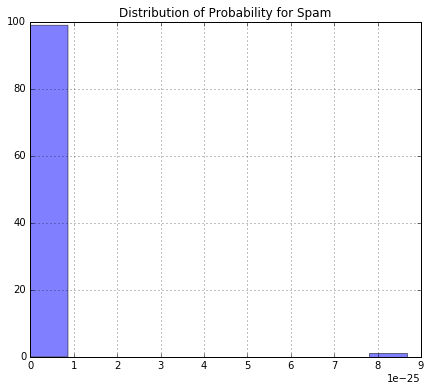

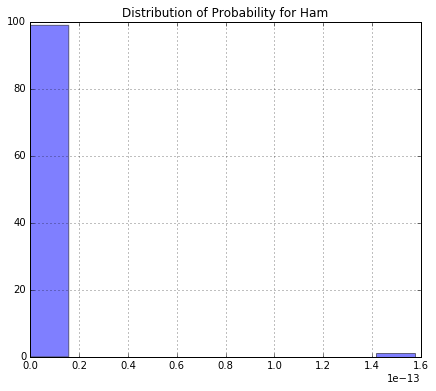

In [650]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

!head -n $(($(wc -l < Classification_23.txt) - 1))  < Classification_23.txt > plot_input.txt

df = pd.read_csv("plot_input.txt",sep='\t',header=None)
df.columns = ['doc_id','true_class','predicted_class','spam','ham']
spam_exp = np.exp(df.spam[df.spam!=0])
df['spam_exp'] = np.where(df['spam']==0, 0.0, np.exp(df['spam']))
df['ham_exp'] = np.where(df['ham']==0, 0.0, np.exp(df['ham']))

plt.figure()
plt.figure(figsize = (7,6), dpi = 72)
plt.title('Distribution of Probability for Spam')
df.spam_exp.hist(alpha=0.5)

plt.figure()
plt.figure(figsize = (7,6), dpi = 72)
plt.title('Distribution of Probability for Ham')
df.ham_exp.hist(alpha=0.5)




In [573]:
## Draw plot 

#### HW2.4 
Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

For a quick reference on the construction of the Multinomial NAIVE BAYES classifier that you will code,
please consult the "Document Classification" section of the following wikipedia page:

https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Document_classification

OR the original paper by the curators of the Enron email data:

http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf

In [574]:
#we will reuse the Mapper 1 from 2.3 

In [607]:
%%writefile reducer1.py
#!/usr/bin/python

from itertools import groupby
from operator import itemgetter
import sys
import re
import math

spam_email_cnt  = 0 # Total count of spam emails 
ham_email_cnt = 0 #Total count of non spam emails 
total_spam_words = 0 #Total count of words in all spam emails 
total_ham_words = 0 # Total count of words in all non spam emails 
spam_words_freq = {} # Dictionary to store overall frequency of words for spam emails
ham_words_freq ={} # Dictionary to store overall frequency of words for non spam emails
unique_word_cnt = 0 # Unique vocab length

for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    key, value = line.split(',', 1)
    
    if(key =="DOC_CLASS"):
        #increment spam or ham count 
        spam_email_cnt += int(value)
        ham_email_cnt += not(int(value))
        continue
    
    # Split the value by <TAB> delimiter
    values = re.split(r'\t+', value)

    #Parse the values
    true_class,freq = int(values[0]), int(values[1])
    word = key
    
    #Determine unique word count for laplace smoothing 
    if (not(word in spam_words_freq or word in ham_words_freq)):
        unique_word_cnt += 1;
    
    #increment spam words, total spam words,ham words, total ham words  based on class of email
    if (true_class == 1):
        total_spam_words += freq;
        if word in spam_words_freq:
            spam_words_freq[word] += freq
        else:
            spam_words_freq[word] = freq
        if word not in ham_words_freq:
            ham_words_freq[word] = 0
    else:
        total_ham_words += freq;
        if word in ham_words_freq:
            ham_words_freq[word] += freq
        else:
            ham_words_freq[word] = freq
        if word not in spam_words_freq:
            spam_words_freq[word] = 0

#Now calculate prior probabilities for spam & ham
p_sp = (1.0)*spam_email_cnt / (spam_email_cnt + ham_email_cnt )
prior_spam = math.log(p_sp)
prior_ham = math.log(1-p_sp)

print "OVERALL,"+str(prior_spam)+","+str(prior_ham)

# Calculate Conditional Probability of word given email class spam and ham
pr_word_spam = {}
pr_word_ham = {}
#One is added here to do LapLace smoothing
for word in ham_words_freq:
    #if findword frequency is greater than 0 than calculate probability else set the value to smallest possible value
    pr_word_spam[word] = math.log((1.0)*(spam_words_freq[word]+1)/ (total_spam_words + unique_word_cnt))     
    pr_word_ham[word] = math.log((1.0)*(ham_words_freq[word]+1)/(total_ham_words + unique_word_cnt))
    
    print word+","+str(pr_word_spam[word])+","+str(pr_word_ham[word])

Overwriting reducer1.py


In [608]:
def hw2_4():
    #remove output directory if present else hadoop job gives error
    !hdfs dfs -rm -r hw2/output/ModelOutput_24
    
    # run map reduce job
    !hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-*streaming*.jar \
    -mapper mapper1.py \
    -reducer reducer1.py \
    -input hw2/src/enronemail_1h.txt \
    -output hw2/output/ModelOutput_24
    
    !hdfs dfs -cat hw2/output/ModelOutput_24/part* > Model_24.txt
    !hdfs dfs -put Model_24.txt hw2/output/ModelOutput_24/

hw2_4()

16/01/25 22:50:59 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/output/ModelOutput_24
16/01/25 22:51:00 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/25 22:51:03 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/25 22:51:05 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### We will reuse reducer2 from HW 2.3

In [609]:
%%writefile mapper2.py
#!/usr/bin/python
# Mapper how Hw1.3.
# This mapper will 
    
import sys
import re
import csv


WORD_RE = re.compile(r"[\w']+")
pr_cc_word={}

#Read the model parameters 
data = None
with open('Model_24.txt', 'rb') as f:
    reader = csv.reader(f)
    for row in reader:
        if(row[0]=="OVERALL"):
            prior_spam = float(row[1])
            prior_ham = float(row[2])
            continue
        pr_cc_word[row[0]]={'spam':float(row[1]),'ham':float(row[2])}

        

#input comes from STDIN (standard input)
for line in sys.stdin:
        # Split the line by <TAB> delimiter
        content = re.split(r'\t+', line)
        # verify correct content structure else ignore bad data
        if len(content) <> 4:
            continue
        #combine email subject and body  and remove leading and trailing spacers
        text = " ".join(content[-2:]).strip()
        # Find all words
        result = re.findall(WORD_RE,text)
        
        pr_spam_doc = prior_spam
        pr_ham_doc = prior_ham
        for w in result:
            word = w.lower()
            # calculate prob for spam , ham for each email 
            if(pr_cc_word[word]['spam'] <> 0):
                pr_spam_doc +=  pr_cc_word[word]['spam']
            else:
                pr_spam_doc += float('-inf')
            if(pr_cc_word[word]['ham'] <> 0):
                pr_ham_doc += pr_cc_word[word]['ham']
            else:
                 pr_ham_doc += float('-inf')

        predicted_class = "0"
        #Determine the predicted class
        if(pr_spam_doc == float('-inf')) :
            predicted_class = "0"
        elif(pr_ham_doc == float('-inf')):
            predicted_class = "1"
        elif(pr_spam_doc > pr_ham_doc):
            predicted_class = "1"
        
        #prepare the value output 
        value = content[1]+"\t" + predicted_class+ "\t" + str(pr_spam_doc)+ "\t" +str(pr_ham_doc)
        
        #emit key. value combination
        print content[0] + "\t" + value

Overwriting mapper2.py


In [610]:
def hw2_41():
    #remove output directory if present else hadoop job gives error
    !hdfs dfs -rm -r hw2/output/ClassificationOutput_24
    
    # run map reduce job
    !hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-*streaming*.jar \
    -mapper mapper2.py  \
    -reducer reducer2.py \
    -input hw2/src/enronemail_1h.txt \
    -output hw2/output/ClassificationOutput_24 \
    -jobconf mapred.reduce.tasks=1

    print "\n"
    print"Training error of Mapreduce Multinomial Naive Bayes with Smoothing \n"
    !hdfs dfs -cat hw2/output/ClassificationOutput_24/part-00000 | tail -1

           
hw2_41()

16/01/25 22:51:15 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/output/ClassificationOutput_24
16/01/25 22:51:16 WARN streaming.StreamJob: -jobconf option is deprecated, please use -D instead.
16/01/25 22:51:16 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Training error of Mapreduce Multinomial Naive Bayes with Smoothing 

16/01/25 22:51:20 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Training error: : 0.000	


#### HW2.5. 
Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset:

#### <span style="color:blue;"> We will re-use Mapper1 from HW 2.3</span> 

#### <span style="color:blue;">Reducer1</span> 

In [611]:
%%writefile reducer1.py
#!/usr/bin/python

from itertools import groupby
from operator import itemgetter
import sys
import re
import math

spam_email_cnt  = 0 # Total count of spam emails 
ham_email_cnt = 0 #Total count of non spam emails 
total_spam_words = 0 #Total count of words in all spam emails 
total_ham_words = 0 # Total count of words in all non spam emails 
spam_words_freq = {} # Dictionary to store overall frequency of words for spam emails
ham_words_freq ={} # Dictionary to store overall frequency of words for non spam emails
unique_word_cnt = 0 # Unique vocab length

for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    key, value = line.split(',', 1)
    
    if(key =="DOC_CLASS"):
        #increment spam or ham count 
        spam_email_cnt += int(value)
        ham_email_cnt += not(int(value))
        continue
    
    # Split the value by <TAB> delimiter
    values = re.split(r'\t+', value)

    #Parse the values
    true_class,freq = int(values[0]), int(values[1])
    word = key
    
    #Determine unique word count for laplace smoothing 
    if (not(word in spam_words_freq or word in ham_words_freq)):
        unique_word_cnt += 1;
    
    #increment spam words, total spam words,ham words, total ham words  based on class of email
    if (true_class == 1):
        total_spam_words += freq;
        if word in spam_words_freq:
            spam_words_freq[word] += freq
        else:
            spam_words_freq[word] = freq
        if word not in ham_words_freq:
            ham_words_freq[word] = 0
    else:
        total_ham_words += freq;
        if word in ham_words_freq:
            ham_words_freq[word] += freq
        else:
            ham_words_freq[word] = freq
        if word not in spam_words_freq:
            spam_words_freq[word] = 0

#Now calculate prior probabilities for spam & ham
p_sp = (1.0)*spam_email_cnt / (spam_email_cnt + ham_email_cnt )
prior_spam = math.log(p_sp)
prior_ham = math.log(1-p_sp)

print "OVERALL,"+str(prior_spam)+","+str(prior_ham)

# Calculate Conditional Probability of word given email class spam and ham
pr_word_spam = {}
pr_word_ham = {}

#if frequency of word is less than 3 ignore the word from vocab 
for word in ham_words_freq:
    if( (ham_words_freq[word]+spam_words_freq[word])<3):
        unique_word_cnt -= 1

#if frequency of word is less than 3 ignore the word and do not calculate the propability
for word in ham_words_freq:
    if( (ham_words_freq[word]+spam_words_freq[word])<3):
        continue
    #One is added here to do LapLace smoothing
    pr_word_spam[word] = math.log((1.0)*(spam_words_freq[word]+1)/ (total_spam_words + unique_word_cnt))     
    pr_word_ham[word] = math.log((1.0)*(ham_words_freq[word]+1)/(total_ham_words + unique_word_cnt))
    print word+","+str(pr_word_spam[word])+","+str(pr_word_ham[word])

Overwriting reducer1.py


In [612]:
def hw2_5():
    #remove output directory if present else hadoop job gives error
    !hdfs dfs -rm -r hw2/output/ModelOutput_25
    
    # run map reduce job
    !hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-*streaming*.jar \
    -mapper mapper1.py \
    -reducer reducer1.py \
    -input hw2/src/enronemail_1h.txt \
    -output hw2/output/ModelOutput_25
    
    !hdfs dfs -cat hw2/output/ModelOutput_25/part* > Model_25.txt
    !hdfs dfs -put Model_25.txt hw2/output/ModelOutput_25/

hw2_5()

16/01/25 22:52:10 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/output/ModelOutput_25
16/01/25 22:52:11 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/25 22:52:15 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/25 22:52:16 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### <span style="color:blue;"> Mapper2</span> 

In [614]:
%%writefile mapper2.py
#!/usr/bin/python
# Mapper for HW 2.4
# This mapper will 
    
import sys
import re
import csv


WORD_RE = re.compile(r"[\w']+")
pr_cc_word={}

#Read the model parameters 
data = None
with open('Model_24.txt', 'rb') as f:
    reader = csv.reader(f)
    for row in reader:
        if(row[0]=="OVERALL"):
            prior_spam = float(row[1])
            prior_ham = float(row[2])
            continue
        pr_cc_word[row[0]]={'spam':float(row[1]),'ham':float(row[2])}

        

#input comes from STDIN (standard input)
for line in sys.stdin:
        # Split the line by <TAB> delimiter
        content = re.split(r'\t+', line)
        # verify correct content structure else ignore bad data
        if len(content) <> 4:
            continue
        #combine email subject and body  and remove leading and trailing spacers
        text = " ".join(content[-2:]).strip()
        # Find all words
        result = re.findall(WORD_RE,text)
        
        pr_spam_doc = prior_spam
        pr_ham_doc = prior_ham
        for w in result:
            word = w.lower()
            # calculate prob for spam , ham for each email
            if(word not in pr_cc_word):
                continue
            pr_spam_doc +=  pr_cc_word[word]['spam']
            pr_ham_doc += pr_cc_word[word]['ham']

        predicted_class = "0"
        #Determine the predicted class
        if(pr_spam_doc == float('-inf')) :
            predicted_class = "0"
        elif(pr_ham_doc == float('-inf')):
            predicted_class = "1"
        elif(pr_spam_doc > pr_ham_doc):
            predicted_class = "1"
        
        #prepare the value output 
        value = content[1]+"\t" + predicted_class+ "\t" + str(pr_spam_doc)+ "\t" +str(pr_ham_doc)
        
        #emit key. value combination
        print content[0] + "\t" + value

Overwriting mapper2.py


In [653]:
def hw2_4_1():
    #remove output directory if present else hadoop job gives error
    !hdfs dfs -rm -r hw2/output/ClassificationOutput_25
    
    # run map reduce job
    !hadoop jar /usr/local/Cellar/hadoop/2.7.1/libexec/share/hadoop/tools/lib/hadoop-*streaming*.jar \
    -mapper mapper2.py  \
    -reducer reducer2.py \
    -input hw2/src/enronemail_1h.txt \
    -output hw2/output/ClassificationOutput_25 \
    -jobconf mapred.reduce.tasks=1

    print "\n"
    print"Training error of Mapreduce Multinomial Naive Bayes with Smoothing \n"
    !hdfs dfs -cat hw2/output/ClassificationOutput_25/part-* | tail -1
    
hw2_4_1()


16/01/25 23:38:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted hw2/output/ClassificationOutput_25
16/01/25 23:38:55 WARN streaming.StreamJob: -jobconf option is deprecated, please use -D instead.
16/01/25 23:38:55 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Training error of Mapreduce Multinomial Naive Bayes with Smoothing 

16/01/25 23:38:58 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Training error: : 0.000	


#### HW2.6 Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm

It always a good idea to benchmark your solutions against publicly available libraries such as SciKit-Learn, The Machine Learning toolkit available in Python. In this exercise, we benchmark ourselves against the SciKit-Learn implementation of multinomial Naive Bayes.  For more information on this implementation see: http://scikit-learn.org/stable/modules/naive_bayes.html more  

In this exercise, please complete the following:

— Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
- Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error
— Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn 

In [488]:
import re
from sklearn.naive_bayes import MultinomialNB
import numpy
from sklearn.feature_extraction.text import CountVectorizer
 
#Create empty arrays for training data and label
email_text = []
train_data = []
train_label =[]

with open ("enronemail_1h.txt", "r") as myfile:
    for line in myfile.readlines():
        
        # Split the line by <TAB> delimiter
        content = re.split(r'\t+', line)
            
        doc_text = content[2].lower() + " "+content[3].lower()         
        email_text.append(doc_text)
        train_label.append(content[1])
    
train_label = np.array(train_label)
    
# Create features for train and dev data 
count_vectorizer = CountVectorizer(min_df=3)
train_data = count_vectorizer.fit_transform(email_text)

nb =  MultinomialNB()
nb.fit(train_data, train_label)   
# Compute accuracy on the test data.
print "Using our Multinomial classifier"
accuracy = nb.score(train_data, train_label)
tr_error = 1-accuracy
print 'sklearn accuracy: %3.2f' %accuracy
print 'sk learn training error %3.2f' %tr_error

Using our Multinomial classifier
sklearn accuracy: 0.96
sk learn training error 0.04


#### HW 2.6 - Summary of Results

| Model                                                                      | Training Error |
|----------------------------------------------------------------------------|----------------|
| Multinomial NB, Scikit-Learn Implementation                                | 0.04            |
| Multinomial NB, MapReduce implementation                                   | 0.0          |